In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random 
from IPython.display import HTML

UnboundLocalError: ignored

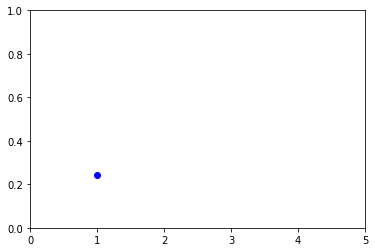

In [21]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
p=np.random.rand(20) ####Ingresando p en points, obtendremos particulas aleatorias en el plot 
x=random.randint(0,5) ##Escoge la posicion x de la particula en un rango de 0 a 5 tomando valores enteros 
y=random.random()    ###Escoge la posicion y de la particula en un rango de 0 a 1 tomando valores flotantes 
points, = ax.plot(x,y, 'bo')  ## creo un plot inicial con la informacion de la particula 

def recorrido():
  ax.set_xlim(0,5)
  ax.set_ylim(0,1)
  return points,



def puntos(x):
  dt=0.01
  vx=2
  vy=0.2
  
  x_paso=x+vx*dt
  y_paso=y+vy*dt
  if x_paso>5 or x_paso<0:
    vx *= -1
    vy *= -1
  if y_paso>1 or y_paso<0:
    vx *= -1
    vy *= -1
  points.set_data(x_paso,y_paso) 
  return points,
  

ani=FuncAnimation(fig,puntos,frames=600,init_func=recorrido,blit=True)
HTML(ani.to_jshtml()) 

(3, 0.5303235915502457)


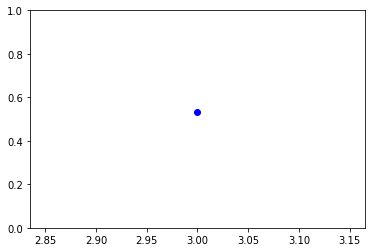

In [14]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
p=np.random.rand(1)
x=random.randint(0,5)
y=random.random()
points = ax.plot(x,y, 'bo')


print((x,y))